In [1]:
import optax
import equinox as eqx
from jax import Array, numpy as jnp, random as jr, vmap, nn

from matplotlib import pyplot as plt

from pets.envs import AtariEnv
from pets.model import Ensemble
from pets.dataset import Dataset

from pets.train import train_step
from pets.agent import sample_episodes, sample_trajectory

In [2]:
def plot(states: Array, pred_states: Array):
    fig, axes = plt.subplots(2, 2, figsize=(6, 4))
    for idx, ax in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
        axes[ax].plot(states[:, 0, idx], c="r")
        axes[ax].plot(pred_states[:, 0, :, idx], c="g", alpha=0.3)
    plt.tight_layout()
    plt.show()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


collected 100000 samples


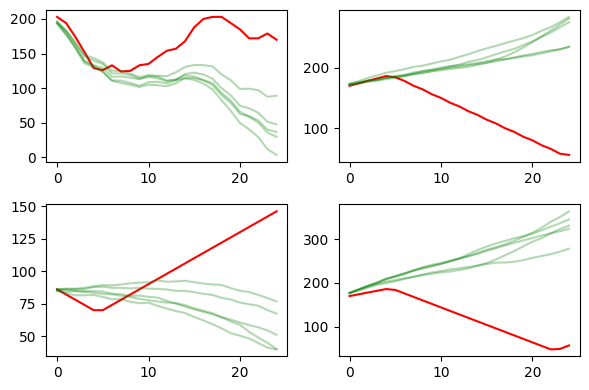

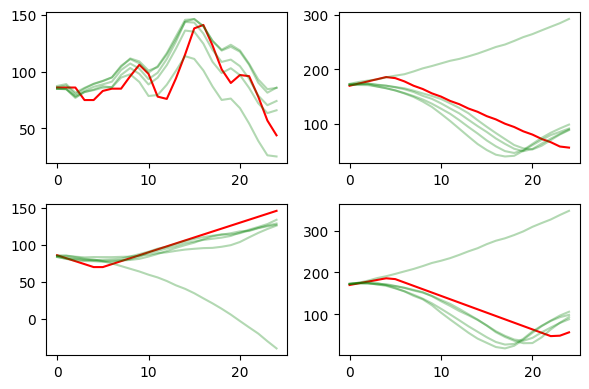

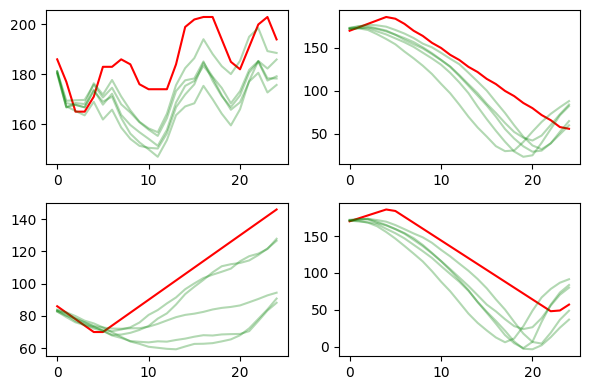

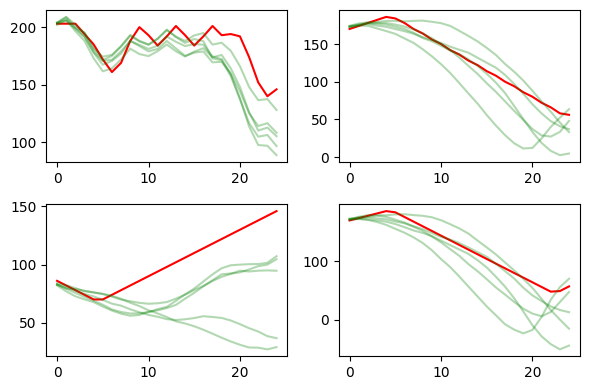

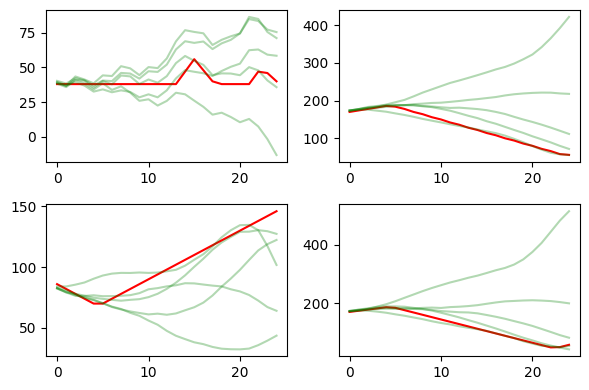

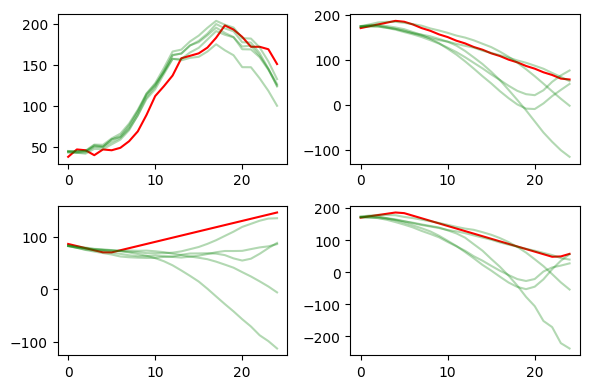

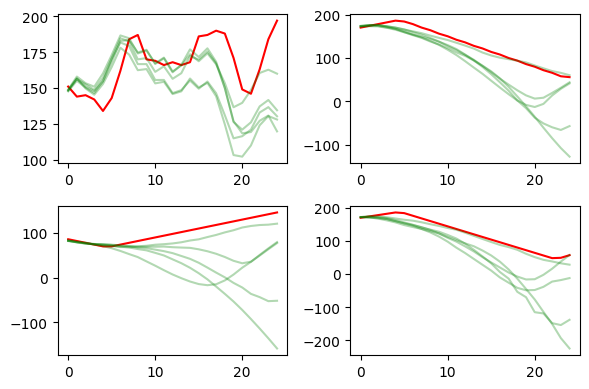

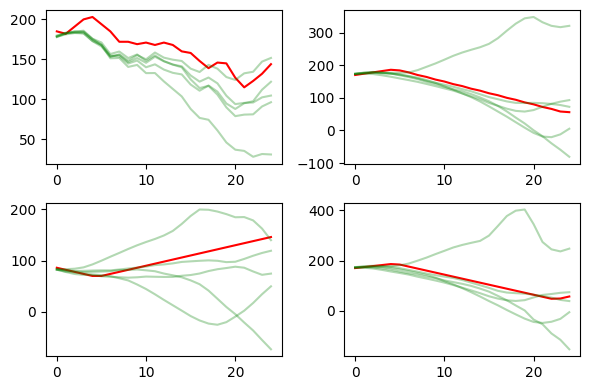

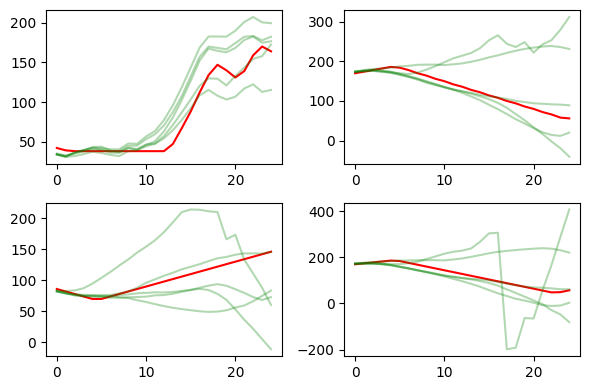

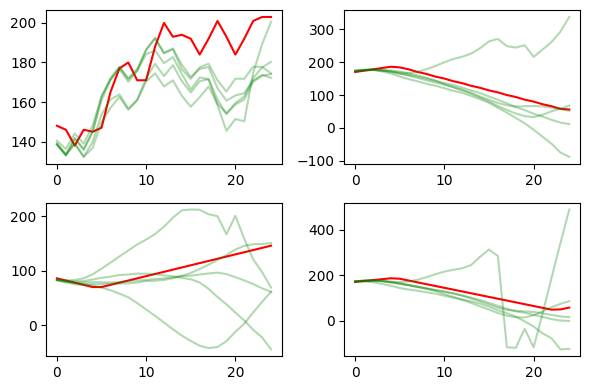

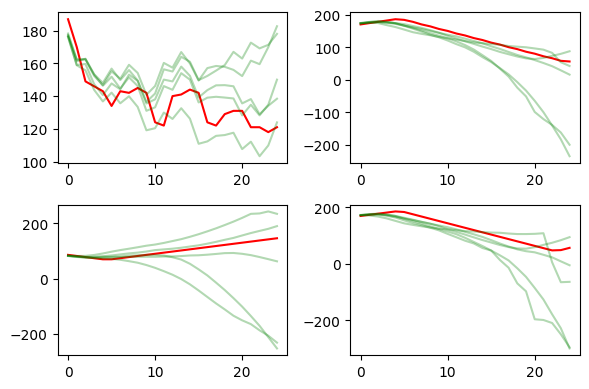

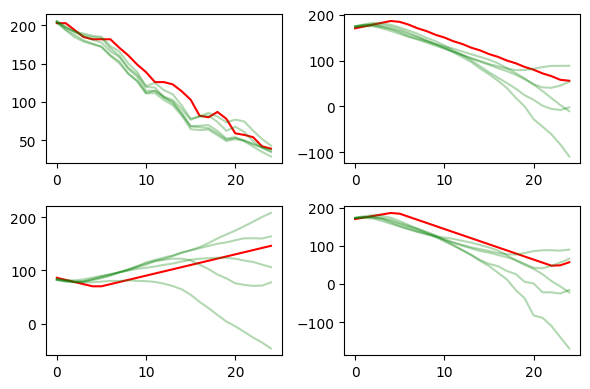

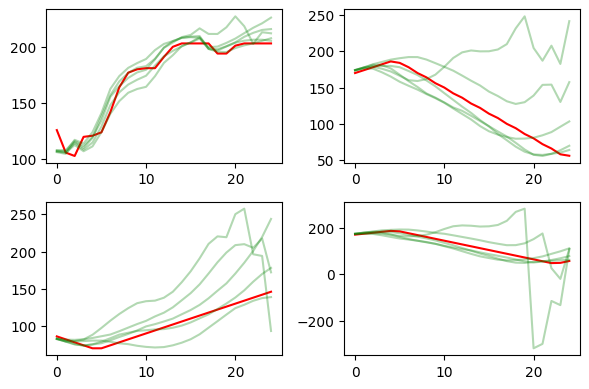

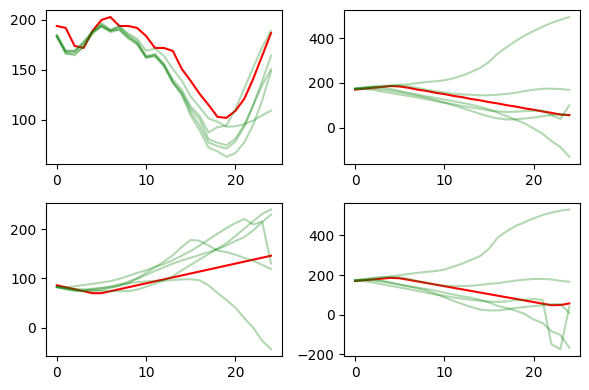

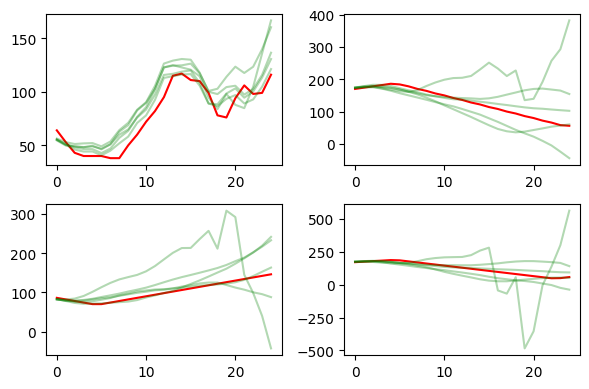

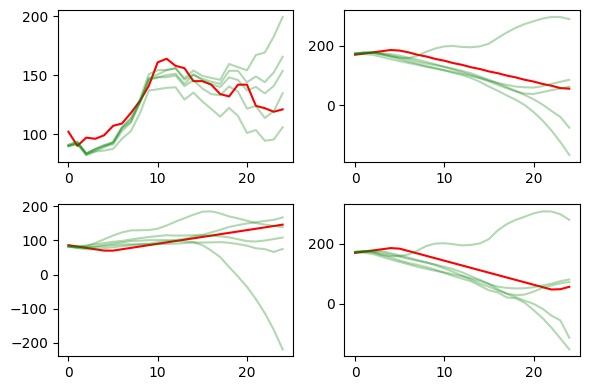

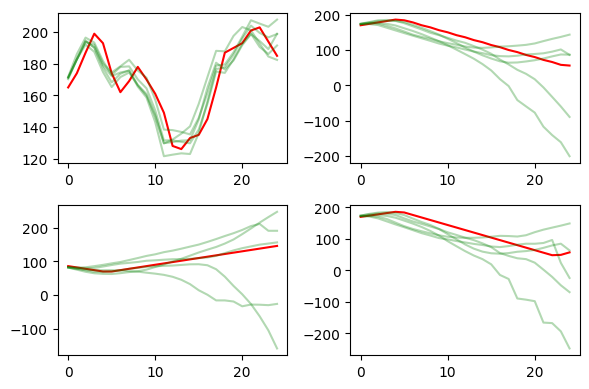

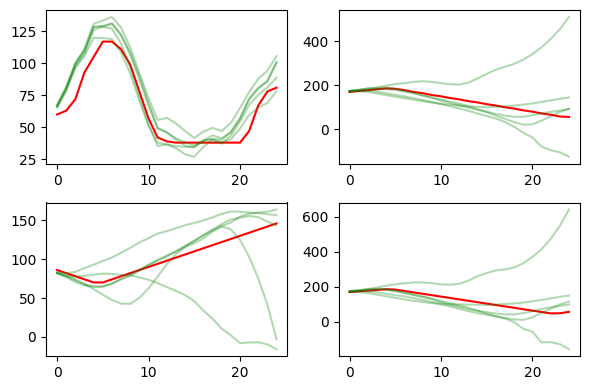

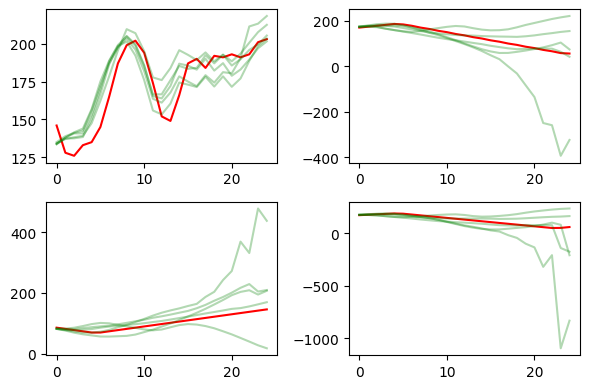

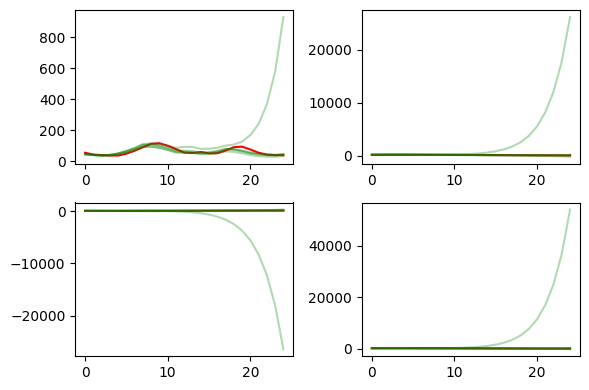

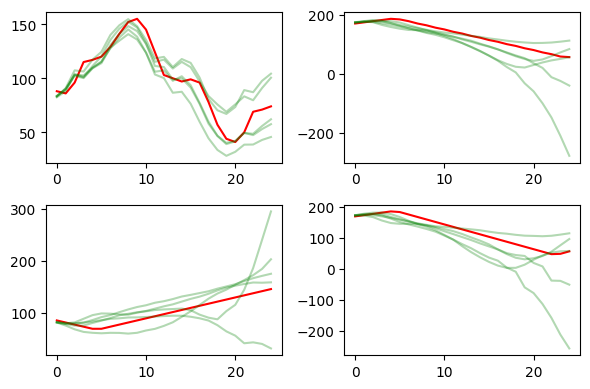

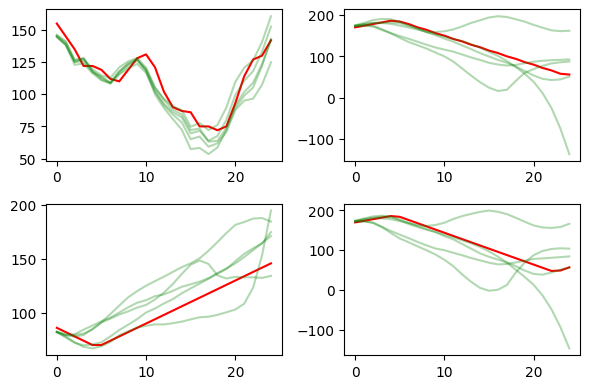

In [3]:
""" experiment parameters """
key = jr.PRNGKey(0)
batch_dim = 32
num_train_epochs = 5
ensemble_dim, hidden_dim = 5, 200
rollout_length, rollout_offset = 50, 25
num_seed_episodes, episode_length = 500, 200

""" environment """ 
env = AtariEnv("PongDeterministic-v4")
state_dim, action_dim = env.observation_space.shape[0], 1

""" dataset """
dataset = Dataset(state_dim, action_dim, ensemble_dim)

""" model """
model = Ensemble(state_dim + action_dim, state_dim, hidden_dim, ensemble_dim, key=key)

""" optimizer """
optim = optax.adamw(learning_rate=1e-4, weight_decay=1e-5, eps=1e-8)
optim_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

""" collect seed data """ 
dataset = sample_episodes(env, dataset, num_seed_episodes, episode_length)
stats = dataset.stats()

""" experiment loop """
while True:

    """ train model """
    for _ in range(num_train_epochs):
        for batch in dataset.batches(batch_dim):
            model, optim_state, _ = train_step(model, batch, stats, optim, optim_state)

    """ test model """ 
    states, actions, rewards, next_states = sample_trajectory(env, rollout_length)
    states, actions = states[rollout_offset:, None, :], actions[rollout_offset:, None, :]
    pred_states = model.rollout(states[0], actions, stats, key=key)
    plot(states, pred_states)

    """ save model & dataset """
    eqx.tree_serialise_leaves("../data/model.eqx", model)
    dataset.save("../data/dataset.pkl")